# Imports

In [ ]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")


modules loaded


#Dataset Preparing

In [ ]:
data_dir = '/content/drive/MyDrive/brain_tumor_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FileSeries = pd.Series(filepaths, name= 'filepaths')
LabelSeries = pd.Series(labels, name='labels')
df = pd.concat([FileSeries, LabelSeries], axis= 1)

#Train Model

In [ ]:
stra = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= stra)

batch_size = 8
img_size = (224, 224)

trn_gen = ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
tst_gen = ImageDataGenerator()


train_gen = trn_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = tst_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [ ]:
img_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l2= 0.023), activation= 'relu'),
    Dropout(rate= 0.45, seed= 42),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',monitor='val_accuracy' ,save_best_only=True , verbose=1  )
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
epochs = 30
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False , callbacks = model_checkpoint)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5812 - loss: 10.9690   
Epoch 1: val_accuracy improved from -inf to 0.49020, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.5820 - loss: 10.9436 - val_accuracy: 0.4902 - val_loss: 11.2892
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7324 - loss: 9.0377
Epoch 2: val_accuracy improved from 0.49020 to 0.82353, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.7313 - loss: 9.0261 - val_accuracy: 0.8235 - val_loss: 7.2151
Epoch 3/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8359 - loss: 6.8671
Epoch 3: val_accuracy improved from 0.82353 to 0.84314, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.8334 - loss: 6.8629 - val_accuracy: 0.8431 - val_loss: 6.7256
Epoch 4/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7442 - loss: 6.7008
Epoch 4: val_accuracy improved from 0.84314 to 0.92157, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.7488 - loss: 6.6462 - val_accuracy: 0.9216 - val_loss: 5.6997
Epoch 5/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8592 - loss: 5.1191
Epoch 5: val_accuracy did not improve from 0.92157
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.8594 - loss: 5.1102 - val_accuracy: 0.8235 - val_loss: 4.9504
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8526 - loss: 4.6122
Epoch 6: val_accuracy did not improve from 0.92157
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.8524 - loss: 4.6041 - val_accuracy: 0.8431 - val_loss: 4.3130
Epoch 7/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8017 - loss: 4.2242
Epoch 7: val_accuracy did not improve from 0.92157
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8013 - loss: 4.2131 - val_accuracy: 0.7059 - val_loss: 7.1400
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8585 - loss: 3.3561
Epoch 8: val_accuracy did not impro

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.8509 - loss: 0.8949 - val_accuracy: 0.9412 - val_loss: 0.9467
Epoch 23/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9414 - loss: 0.8585
Epoch 23: val_accuracy did not improve from 0.94118
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.9406 - loss: 0.8496 - val_accuracy: 0.9020 - val_loss: 0.7761
Epoch 24/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9324 - loss: 0.6248
Epoch 24: val_accuracy did not improve from 0.94118
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9323 - loss: 0.6212 - val_accuracy: 0.8627 - val_loss: 1.3522
Epoch 25/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9747 - loss: 0.4861
Epoch 25: val_accuracy did not improve from 0.94118
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9749 - loss: 0.4848 - val_accuracy: 0.9412 - val_loss: 1.3050
Epoch 26/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9247 - loss: 0.5240
Epoch 26: val_accuracy did n

#Graphs to Show the Best Epoch

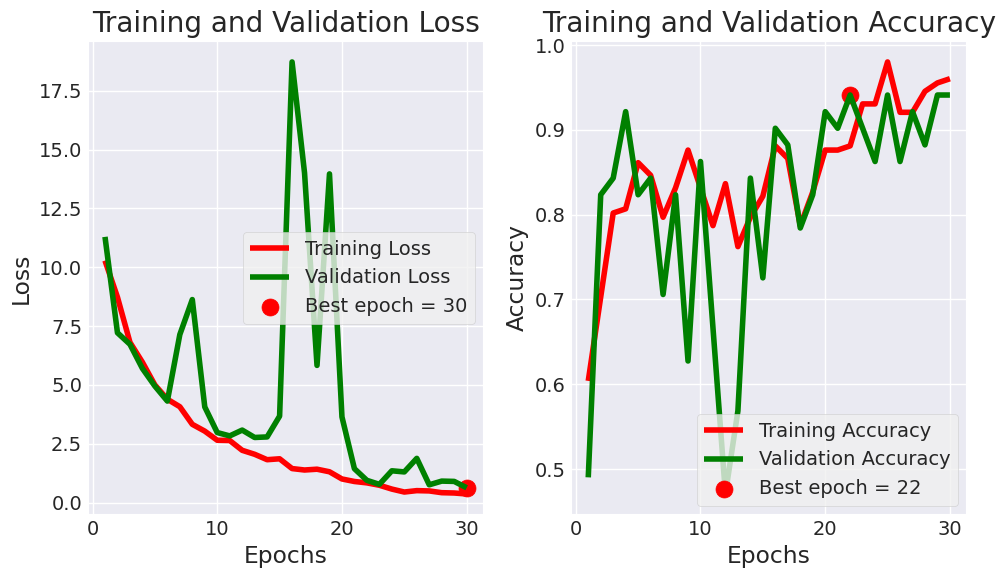

In [ ]:
history_data = history.history
epochs = range(1, len(history_data['accuracy']) + 1)

best_loss_epoch = np.argmin(history_data['val_loss']) + 1
best_loss_value = history_data['val_loss'][best_loss_epoch - 1]

best_acc_epoch = np.argmax(history_data['val_accuracy']) + 1
best_acc_value = history_data['val_accuracy'][best_acc_epoch - 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
plt.style.use("fivethirtyeight")

axes[0].plot(epochs, history_data['loss'], 'r', label='Training Loss')
axes[0].plot(epochs, history_data['val_loss'], 'g', label='Validation Loss')
axes[0].scatter(best_loss_epoch, best_loss_value, s=150, c='red',
                label=f'Best epoch = {best_loss_epoch}')
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(epochs, history_data['accuracy'], 'r', label='Training Accuracy')
axes[1].plot(epochs, history_data['val_accuracy'], 'g', label='Validation Accuracy')
axes[1].scatter(best_acc_epoch, best_acc_value, s=150, c='red',
                label=f'Best epoch = {best_acc_epoch}')
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


#Model Evaluation

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


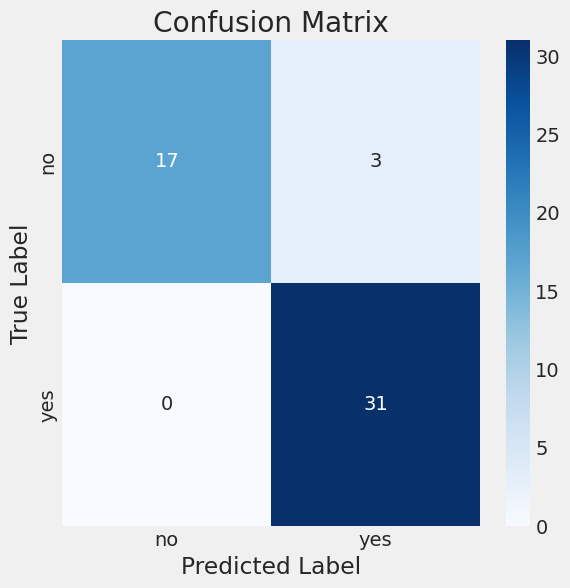

In [ ]:
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= list(test_gen.class_indices.keys())))

              precision    recall  f1-score   support

          no       1.00      0.85      0.92        20
         yes       0.91      1.00      0.95        31

    accuracy                           0.94        51
   macro avg       0.96      0.93      0.94        51
weighted avg       0.95      0.94      0.94        51



#Saving Model

In [ ]:
model.save('brain_tumor_best_model.h5')

#Deployment

In [ ]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.7 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/brain_tumor_best_model(94%).h5")

# Class names (adjust based on your dataset)
class_names = ["No Tumor is Existed", "Yes, Tumor is Existed"]

st.title("✅ Brain Tumor Classifier")

# File uploader
uploaded_file = st.file_uploader("Upload an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)
    img = image.resize((224,224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions)
    confidence = np.max(predictions)

    st.write(f"**Prediction:** {class_names[class_idx]}")
    st.write(f"**Confidence:** {confidence:.2f}")


Writing app.py


In [ ]:
from pyngrok import ngrok

!ngrok authtoken 32ydGdDOgOjCsc4tTBC3BHzNkxn_Yst36K3NC5idFvCncy4h

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Start streamlit
get_ipython().system_raw('streamlit run app.py --server.port 8501 &')

# Expose port 8501 via ngrok
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://e7cbd81e2462.ngrok-free.app" -> "http://localhost:8501"
